# Internet of Things (2IMN25)
### Machine Learning Assignment

### Introduction

The objective of the assignment is to use supervised machine learning techniques to make predictions about the net energy consumed based on the weather conditions. This will be accomplished by training a regression model on (real) data obtained from the weather sensor and energy meter over this year. This model will then be used to make predictions about the net energy consumption for data-points not *seen* by the model during training.

In [2]:
""" Import all libraries here """
import numpy as np
import os
import math
from datetime import datetime
import pandas as pd
from dateutil import parser
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder

## Reading the dataset

In the code box below, please read in the data-sets into suitable data structures. The key task here would be to contruct the feature vectors which would be fed to the regression algorithm.

The datasets for the weather, rain and energy consumption have been provided in the zip file, extract this zip file into the same folder as the python notebook. The function should read both the weather and rainfall datafiles and create a merged feature vector array based on time-stamps.



In [3]:
def merge_weather_rain_data(data_path): # Select month for which data is collected
    """ 
    Reads in the CSV files for weather and rain data
    Merged them into a single array based on matching time-stamps
    
    """
        
    """ Read in the weather"""
    weatherFrame = pd.read_csv(os.path.join(data_path,'Weather-Eindhoven.csv'),
                             delimiter = ',',
                             header=0,
                             parse_dates = [0],
                             usecols = [0,1,2,4,6,7,8]) #Drop "chill", too many missing values
    weather_array  = weatherFrame.as_matrix()

    """ Read in the rain data"""
    rainFrame = pd.read_csv(os.path.join(data_path,'Rain-Best.csv'),
                             delimiter = ',',
                             header =  None,
                             skiprows = 1,
                             index_col = None,
                             parse_dates = [0]
                            )
    rain_array = rainFrame.as_matrix()

    """ Synchronize the 2 data-sets by removing the extra data from the rainfall dataset"""
    remove_rows = []
    for element,idx in zip(rain_array[:,0],range(len(rain_array[:,0]))):
        if element.minute%10 != 0:
            remove_rows.append(idx)

    synced_rain_array = np.delete(rain_array,remove_rows,axis = 0)

    print(synced_rain_array.shape)
    print(weather_array[:,0].shape)

    """ Merge the weather and rain data when time-stamps are equal """
    merged_array = []
    for rainElem in synced_rain_array:
        try :
            merged_row = []
            valid_row = list(weather_array[:,0]).index(rainElem[0])
            for weatherFeature in weather_array[valid_row]:
                merged_row.append(weatherFeature)
            merged_row.append(rainElem[1])
            merged_row.append(weather_array[valid_row][0].hour) # Add "time of day" information 
            merged_array.append(np.asarray(merged_row))
        except ValueError:
            print('Did not find matching timestamp in the weather data, continuing')
            continue

    merged_array = np.asarray(merged_array)
    return merged_array

# Create the merged array
data_path = os.path.join(os.getcwd(),'data')
merged_array = merge_weather_rain_data(data_path)

(43844, 2)
(43872,)
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matchin

## Cleaning the data

The datafiles may contain missing entries, in such an event, it is needed to get rid of such datapoints. The function should take in the created feature vector array and delete rows if features are missing.


In [4]:

def clean_up(merged_array):
    """ 
    Clean up the data by removing rows with missing data points 
    
    """
    missing_data_rows = []
    for row,idx in zip(merged_array,range(merged_array.shape[0])):
        for elem in row[1:]: #Timestamp,Description cannot be "checked"
            if pd.isnull(elem):
                missing_data_rows.append(idx)
                break # To prevent the same row from being added multiple times to the list, break when the first "nan" is found
    clean_data_array = np.delete(merged_array,missing_data_rows,axis=0)
    return clean_data_array

def filter_by_month(data_array,month):
    """
    Filter weather data by month
    
    """
    rows_delete = []
    for row,idx in zip(data_array,range(data_array.shape[0])):
        if row[0].month != month and row[0].month != (month+1) and row[0].month != (month+2):
            rows_delete.append(idx)
    filtered_array = np.delete(data_array,rows_delete,axis=0)
    return filtered_array

clean_data_array = clean_up(merged_array)
month_array = filter_by_month(clean_data_array,month = 7)
print(month_array.shape)

(13171, 9)


## Reading in the energy values

The aim of the assignment is to predict the solar energy produced based on the weather conditions. Thus, for each weather datapoint, the solar energy must be calclulated using the energy datafiles and matching the time-stamps. Define a function that first creates a single datastructure from all the different energy files. Then, design a function that can perform an energy look-up based on the time-stamp of the weather data. This fucntion should return the total solar energy produced between the previous timestamp and current timestamp.Using this look-up function, loop over all the time-stamps of the weather data and generate energy labels. It should be noted, that for certain time-stamps, the energy values might be missing, datapoints corresponding to such timestamps must be deleted from the data array. 

*Hint : Check the documentation for the python package pandas to design a fast lookup function*

In [5]:
def create_dataframe(energyDir):
    """ 
    Returns a dataframe that is formed by concatenating all the energy data files 
    """
    fileList = []
    energyDir = os.path.join(os.getcwd(),energyDir)
    dirList = [os.path.join(energyDir, o) for o in os.listdir(energyDir) 
                    if os.path.isdir(os.path.join(energyDir,o))]
    
    sortedDirList = sorted(dirList)
    for direc in sortedDirList:
        dirFiles = [os.path.join(direc, f) for f in os.listdir(direc) 
                    if os.path.isfile(os.path.join(direc,f))]
        for f in dirFiles:
            fileList.append(f)
        
    fileList = sorted(fileList)
    frame = pd.DataFrame()
    frameList = []
    for f in fileList:
        try:
            df = pd.read_csv(f,index_col=None, header=None,parse_dates=[[0,1]],skipfooter=2)
            frameList.append(df)
        except:
            continue
    frame = pd.concat(frameList)
    sparseFrame = frame.drop([2,3,4,5,6,7,8,9,13],axis=1)
    sparseFrame.columns = ['TimeStamp','Energy Consumed','Energy Produced','Solar Energy Produced']
    return sparseFrame
    
def energy_frame_month(energyDir,month):
    """
    Create an energy frame for only the specified month
    
    """
    energyDir = os.path.join(os.getcwd(),energyDir)
    if month < 10:
        monthDir = os.path.join(energyDir,'0{}'.format(month))
    else:
        monthDir = os.path.join(energyDir,'{}'.format(month))
        
    dirFiles = [os.path.join(monthDir, f) for f in os.listdir(monthDir) 
                    if os.path.isfile(os.path.join(monthDir,f))]
    fileList = []
    for f in dirFiles:
        fileList.append(f)
        fileList = sorted(fileList)
    frame = pd.DataFrame()
    frameList = []
    for f in fileList:
        try:
            df = pd.read_csv(f,index_col=None, header=None,parse_dates=[[0,1]],skipfooter=2)
            frameList.append(df)
        except:
            continue
    frame = pd.concat(frameList)
    sparseFrame = frame.drop([2,3,4,5,6,7,8,9,13],axis=1)
    sparseFrame.columns = ['TimeStamp','Energy Consumed','Energy Produced','Solar Energy Produced']
    return sparseFrame

    
def multi_month_frame(start_month,num_months):
    """
    Concatenates for a given number of months w.r.t a start month
    
    """
    frameList = []
    for step in range(num_months):
        frameList.append(energy_frame_month('data/2017',month = start_month+step))
    return pd.concat(frameList)

energyFrame_conc = multi_month_frame(start_month = 7,num_months = 3)
print(energyFrame_conc)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:52: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


               TimeStamp  Energy Consumed  Energy Produced  \
0    2017-07-01 00:00:01              860                0   
1    2017-07-01 00:00:11             1030                0   
2    2017-07-01 00:00:21             1020                0   
3    2017-07-01 00:00:31             1110                0   
4    2017-07-01 00:00:41             1010                0   
5    2017-07-01 00:00:51              880                0   
6    2017-07-01 00:01:01             1000                0   
7    2017-07-01 00:01:11              880                0   
8    2017-07-01 00:01:21             1010                0   
9    2017-07-01 00:01:31             1010                0   
10   2017-07-01 00:01:41              880                0   
11   2017-07-01 00:01:51             1020                0   
12   2017-07-01 00:02:01              880                0   
13   2017-07-01 00:02:11              990                0   
14   2017-07-01 00:02:21              870                0   
15   201

In [7]:
def energy_lookup(data_array,energyFrame,idx):
    """ 
    Given the index, calculated the net-energy consumed in the 10-minute interval preceeding current time
    
    """
    try:
        subFrame = energyFrame[(energyFrame['TimeStamp']>data_array[idx-1][0]) & (energyFrame['TimeStamp']<data_array[idx][0])]
        if subFrame.shape[0] == 0:
            return None,None
        energyList = []
        solarList = []
        for cons,prod,solar in zip(subFrame['Energy Consumed'],subFrame['Energy Produced'],subFrame['Solar Energy Produced']):
            energyList.append(cons-prod)
            solarList.append(solar)
        return np.sum(np.asarray(energyList)),np.sum(np.asarray(solar))
    except:
        return None,None

def create_labels(data_array,energyFrame):
    """
    Uses the look-up function to create labels (if possible)
    for every feature vector in the feature array.
    
    """
    
    missing_labels = []
    labels = []
    labels_solar = []
    labels.append(0)
    labels_solar.append(0)
    energyFrame['TimeStamp'] = pd.to_datetime(energyFrame['TimeStamp']) 
    for row,idx in zip(data_array,range(data_array.shape[0])):
        if idx == 0:
            continue
        netEnergy,netSolar = energy_lookup(data_array,energyFrame,idx)
        if netEnergy is None and netSolar is None:
            print('Missing label for row {}'.format(idx))
            missing_labels.append(idx)
        else:
            print('{} {} {}'.format(row[0],netEnergy,netSolar))
            labels.append(netEnergy)
            labels_solar.append(netSolar)
    return labels,labels_solar,missing_labels

labels,labels_solar,missing_labels = create_labels(month_array,energyFrame_conc)
featureArray = np.delete(month_array,missing_labels,axis=0)
            

2017-07-01 00:10:00 55550 0
2017-07-01 00:20:00 51920 0
2017-07-01 00:30:00 76330 0
2017-07-01 00:40:00 47950 0
2017-07-01 00:50:00 46520 0
2017-07-01 01:00:00 46610 0
2017-07-01 01:10:00 40380 0
2017-07-01 01:20:00 45540 0
2017-07-01 01:30:00 34430 0
2017-07-01 01:40:00 39770 0
2017-07-01 01:50:00 43950 0
2017-07-01 02:00:00 27720 0
2017-07-01 02:10:00 25060 0
2017-07-01 02:20:00 18700 0
2017-07-01 02:30:00 14050 0
2017-07-01 02:40:00 20250 0
2017-07-01 02:50:00 52530 0
2017-07-01 03:00:00 24530 0
2017-07-01 03:10:00 19160 0
2017-07-01 03:20:00 16510 0
2017-07-01 03:30:00 14400 0
2017-07-01 03:40:00 12530 0
2017-07-01 03:50:00 10230 0
2017-07-01 04:00:00 8400 0
2017-07-01 04:10:00 12280 0
2017-07-01 04:20:00 8580 0
2017-07-01 04:30:00 9210 0
2017-07-01 04:40:00 18460 0
2017-07-01 04:50:00 19870 0
2017-07-01 05:00:00 20760 0
2017-07-01 05:10:00 21150 0
2017-07-01 05:20:00 14990 0
2017-07-01 05:30:00 14930 0
2017-07-01 05:40:00 12370 0
2017-07-01 05:50:00 8240 0
2017-07-01 06:00:00 1099

2017-07-03 02:20:00 12000 0
2017-07-03 02:30:00 11950 0
2017-07-03 02:40:00 10200 0
2017-07-03 02:50:00 18160 0
2017-07-03 03:00:00 24270 0
2017-07-03 03:10:00 20710 0
2017-07-03 03:20:00 21840 0
2017-07-03 03:30:00 19070 0
2017-07-03 03:40:00 11550 0
2017-07-03 03:50:00 10900 0
2017-07-03 04:00:00 29910 0
2017-07-03 04:10:00 9620 0
2017-07-03 04:20:00 10130 0
2017-07-03 04:30:00 19190 0
2017-07-03 04:40:00 15590 0
2017-07-03 04:50:00 15020 0
2017-07-03 05:00:00 15520 0
2017-07-03 05:10:00 10200 0
2017-07-03 05:20:00 9600 0
2017-07-03 05:30:00 12640 0
2017-07-03 05:40:00 10730 54
2017-07-03 05:50:00 8930 64
2017-07-03 06:00:00 16360 72
2017-07-03 06:10:00 19350 78
2017-07-03 06:20:00 20380 58
2017-07-03 06:30:00 19190 89
2017-07-03 06:40:00 16790 57
2017-07-03 06:50:00 13700 9
2017-07-03 07:00:00 27280 278
2017-07-03 07:10:00 -11630 498
2017-07-03 07:20:00 -21160 553
2017-07-03 07:30:00 6980 661
2017-07-03 07:40:00 -3770 738
2017-07-03 07:50:00 -23850 870
2017-07-03 08:00:00 -42650 956

2017-07-05 05:40:00 18640 0
2017-07-05 05:50:00 37460 66
2017-07-05 06:00:00 8280 39
2017-07-05 06:10:00 8190 100
2017-07-05 06:20:00 12250 71
2017-07-05 06:30:00 9290 48
2017-07-05 06:40:00 12530 57
2017-07-05 06:50:00 16110 59
2017-07-05 07:00:00 15450 57
2017-07-05 07:10:00 8830 271
2017-07-05 07:20:00 -3200 494
2017-07-05 07:30:00 -13100 512
2017-07-05 07:40:00 15600 546
2017-07-05 07:50:00 17140 618
2017-07-05 08:00:00 -20180 824
2017-07-05 08:10:00 -11240 489
2017-07-05 08:20:00 -8980 917
2017-07-05 08:30:00 -15410 543
2017-07-05 08:40:00 -21090 675
2017-07-05 08:50:00 -29850 490
2017-07-05 09:00:00 -62930 1300
2017-07-05 09:10:00 -65810 1285
2017-07-05 09:20:00 -68790 1369
2017-07-05 09:30:00 -74810 1367
2017-07-05 09:40:00 -76540 1501
2017-07-05 09:50:00 -72240 1605
2017-07-05 10:00:00 -76210 1660
2017-07-05 10:10:00 -84360 1753
2017-07-05 10:20:00 -58490 1295
2017-07-05 10:30:00 -72810 1544
2017-07-05 10:40:00 -76220 1804
2017-07-05 10:50:00 -90920 1925
2017-07-05 11:00:00 -84

2017-07-07 04:10:00 14210 0
2017-07-07 04:20:00 31110 0
2017-07-07 04:30:00 12570 0
2017-07-07 04:40:00 13320 0
2017-07-07 04:50:00 16820 0
2017-07-07 05:00:00 18790 0
2017-07-07 05:10:00 15080 0
2017-07-07 05:20:00 18530 0
2017-07-07 05:30:00 16060 0
2017-07-07 05:40:00 12100 0
2017-07-07 05:50:00 12590 58
2017-07-07 06:00:00 8930 70
2017-07-07 06:10:00 12300 90
2017-07-07 06:20:00 8300 122
2017-07-07 06:30:00 19120 68
2017-07-07 06:40:00 23500 54
2017-07-07 06:50:00 20570 48
2017-07-07 07:00:00 23440 78
2017-07-07 07:10:00 7750 348
2017-07-07 07:20:00 -5350 412
2017-07-07 07:30:00 -11340 526
2017-07-07 07:40:00 -9590 651
2017-07-07 07:50:00 -26370 899
2017-07-07 08:00:00 -23790 844
2017-07-07 08:10:00 -5270 540
2017-07-07 08:20:00 -19660 570
2017-07-07 08:30:00 -870 348
2017-07-07 08:40:00 -12620 539
2017-07-07 08:50:00 -47950 1180
2017-07-07 09:00:00 -53910 1268
2017-07-07 09:10:00 -60700 1248
2017-07-07 09:20:00 -68490 1481
2017-07-07 09:30:00 -70470 1554
2017-07-07 09:40:00 -78450

2017-07-09 13:20:00 21769 1363
2017-07-09 13:30:00 -101800 2205
2017-07-09 13:40:00 -110208 2277
2017-07-09 13:50:00 -86210 2170
2017-07-09 14:00:00 -55091 1884
2017-07-09 14:10:00 -69990 2193
2017-07-09 14:20:00 -89400 1830
2017-07-09 14:30:00 -78750 1945
2017-07-09 14:40:00 -64570 1752
2017-07-09 14:50:00 -67440 1540
2017-07-09 15:00:00 -68320 1654
2017-07-09 15:10:00 -72570 1896
2017-07-09 15:20:00 -62700 1742
2017-07-09 15:30:00 -56270 1535
2017-07-09 15:40:00 -43310 1279
2017-07-09 15:50:00 -39640 1112
2017-07-09 16:00:00 -65620 1358
2017-07-09 16:10:00 -49140 888
2017-07-09 16:20:00 -51130 1147
2017-07-09 16:30:00 -39250 1452
2017-07-09 16:40:00 -50020 1316
2017-07-09 16:50:00 -39160 1250
2017-07-09 17:00:00 -40730 1227
2017-07-09 17:10:00 -25590 1059
2017-07-09 17:20:00 -14790 566
2017-07-09 17:30:00 -13710 777
2017-07-09 17:40:00 23550 821
2017-07-09 17:50:00 -9870 765
2017-07-09 18:00:00 -4360 624
2017-07-09 18:10:00 -4120 569
2017-07-09 18:20:00 26170 372
2017-07-09 18:30:00 

2017-07-11 14:40:00 -22470 850
2017-07-11 14:50:00 -11490 371
2017-07-11 15:00:00 -26180 899
2017-07-11 15:10:00 -12520 537
2017-07-11 15:20:00 22290 311
2017-07-11 15:30:00 -11270 774
2017-07-11 15:40:00 -36790 1108
2017-07-11 15:50:00 -15070 771
2017-07-11 16:00:00 -1380 472
2017-07-11 16:10:00 42360 285
2017-07-11 16:20:00 10130 568
2017-07-11 16:30:00 -9610 868
2017-07-11 16:40:00 -11510 819
2017-07-11 16:50:00 -6880 754
2017-07-11 17:00:00 540 608
2017-07-11 17:10:00 3210 581
2017-07-11 17:20:00 -5560 481
2017-07-11 17:30:00 9640 349
2017-07-11 17:40:00 14130 264
2017-07-11 17:50:00 14060 326
2017-07-11 18:00:00 18430 366
2017-07-11 18:10:00 23370 404
2017-07-11 18:20:00 31180 559
2017-07-11 18:30:00 40439 532
2017-07-11 18:40:00 29980 216
2017-07-11 18:50:00 31840 321
2017-07-11 19:00:00 52268 267
2017-07-11 19:10:00 43523 235
2017-07-11 19:20:00 20270 227
2017-07-11 19:30:00 17910 145
2017-07-11 19:40:00 48610 131
2017-07-11 19:50:00 88830 88
2017-07-11 20:00:00 101720 86
2017-0

2017-07-13 14:00:00 -94419 1254
2017-07-13 14:10:00 -99119 1865
2017-07-13 14:20:00 -97519 2406
2017-07-13 14:30:00 -116250 2554
2017-07-13 14:40:00 -127620 2470
2017-07-13 14:50:00 -85039 756
2017-07-13 15:00:00 -74340 2528
2017-07-13 15:10:00 -74989 1487
2017-07-13 15:20:00 -78889 2245
2017-07-13 15:30:00 -104840 1311
2017-07-13 15:40:00 -50320 772
2017-07-13 15:50:00 -48600 793
2017-07-13 16:00:00 -74200 1703
2017-07-13 16:10:00 -45720 868
2017-07-13 16:20:00 -56470 1160
2017-07-13 16:30:00 -24080 624
2017-07-13 16:40:00 -23770 636
2017-07-13 16:50:00 -67460 1705
2017-07-13 17:00:00 -41260 564
2017-07-13 17:10:00 -45580 1336
2017-07-13 17:20:00 -9160 496
2017-07-13 17:30:00 -5220 332
2017-07-13 17:40:00 12220 367
2017-07-13 17:50:00 -14910 532
2017-07-13 18:30:00 -41010 436
2017-07-13 18:40:00 -9040 588
2017-07-13 18:50:00 -10100 447
2017-07-13 19:00:00 950 471
2017-07-13 19:10:00 1990 310
2017-07-13 19:20:00 -1280 245
2017-07-13 19:30:00 1210 254
2017-07-13 19:40:00 4210 250
2017-0

2017-07-15 18:20:00 -16230 394
2017-07-15 18:30:00 -12890 360
2017-07-15 18:40:00 13670 328
2017-07-15 18:50:00 50110 308
2017-07-15 19:00:00 1670 309
2017-07-15 19:10:00 8690 264
2017-07-15 19:20:00 870 307
2017-07-15 19:30:00 480 216
2017-07-15 19:40:00 37260 209
2017-07-15 19:50:00 11780 155
2017-07-15 20:00:00 1450 140
2017-07-15 20:10:00 9000 146
2017-07-15 20:20:00 74144 134
2017-07-15 20:30:00 8360 140
2017-07-15 20:40:00 6860 108
2017-07-15 20:50:00 7740 92
2017-07-15 21:00:00 6530 78
2017-07-15 21:10:00 34360 75
2017-07-15 21:20:00 9520 63
2017-07-15 21:30:00 12950 49
2017-07-15 21:40:00 19540 0
2017-07-15 21:50:00 19430 0
2017-07-15 22:00:00 17780 0
2017-07-15 22:10:00 16690 0
2017-07-15 22:20:00 18850 0
2017-07-15 22:30:00 13350 0
2017-07-15 22:40:00 13430 0
2017-07-15 22:50:00 16610 0
2017-07-15 23:00:00 14830 0
2017-07-15 23:10:00 13900 0
2017-07-15 23:20:00 17240 0
2017-07-15 23:30:00 9240 0
2017-07-15 23:40:00 30679 0
2017-07-15 23:50:00 11870 0
2017-07-16 00:00:00 9990 

2017-07-17 21:30:00 42080 63
2017-07-17 21:40:00 50400 56
2017-07-17 21:50:00 42460 0
2017-07-17 22:00:00 48630 0
2017-07-17 22:10:00 40300 0
2017-07-17 22:20:00 39880 0
2017-07-17 22:30:00 64090 0
2017-07-17 22:40:00 37820 0
2017-07-17 22:50:00 38840 0
2017-07-17 23:00:00 43540 0
2017-07-17 23:10:00 38600 0
2017-07-17 23:20:00 44980 0
2017-07-17 23:30:00 41820 0
2017-07-17 23:40:00 33330 0
2017-07-17 23:50:00 32950 0
2017-07-18 00:00:00 33320 0
2017-07-18 00:10:00 36250 0
2017-07-18 00:20:00 34800 0
2017-07-18 00:30:00 35610 0
2017-07-18 00:40:00 31020 0
2017-07-18 00:50:00 29970 0
2017-07-18 01:00:00 28710 0
2017-07-18 01:10:00 43880 0
2017-07-18 01:20:00 23740 0
2017-07-18 01:30:00 22020 0
2017-07-18 01:40:00 20420 0
2017-07-18 01:50:00 22980 0
2017-07-18 02:00:00 24400 0
2017-07-18 02:10:00 18510 0
2017-07-18 02:20:00 24530 0
2017-07-18 02:30:00 21920 0
2017-07-18 02:40:00 15760 0
2017-07-18 02:50:00 17330 0
2017-07-18 03:00:00 16180 0
2017-07-18 03:10:00 10810 0
2017-07-18 03:20:0

Missing label for row 2680
Missing label for row 2681
Missing label for row 2682
Missing label for row 2683
Missing label for row 2684
Missing label for row 2685
Missing label for row 2686
Missing label for row 2687
Missing label for row 2688
Missing label for row 2689
2017-07-20 00:10:00 43130 0
2017-07-20 00:20:00 38760 0
2017-07-20 00:30:00 42200 0
2017-07-20 00:40:00 34900 0
2017-07-20 00:50:00 104010 0
2017-07-20 01:00:00 169260 0
2017-07-20 01:10:00 135500 0
2017-07-20 01:20:00 111190 0
2017-07-20 01:30:00 106030 0
2017-07-20 01:40:00 116750 0
2017-07-20 01:50:00 119320 0
2017-07-20 02:00:00 97860 0
2017-07-20 02:10:00 50430 0
2017-07-20 02:20:00 26460 0
2017-07-20 02:30:00 20970 0
2017-07-20 02:40:00 22720 0
2017-07-20 02:50:00 22590 0
2017-07-20 03:00:00 23760 0
2017-07-20 03:10:00 28070 0
2017-07-20 03:20:00 25350 0
2017-07-20 03:30:00 24910 0
2017-07-20 03:40:00 26520 0
2017-07-20 03:50:00 21580 0
2017-07-20 04:00:00 16610 0
2017-07-20 04:10:00 14960 0
2017-07-20 04:20:00 132

2017-07-22 01:10:00 39770 0
2017-07-22 01:20:00 31790 0
2017-07-22 01:30:00 31680 0
2017-07-22 01:40:00 27310 0
2017-07-22 01:50:00 20030 0
2017-07-22 02:00:00 21670 0
2017-07-22 02:10:00 14900 0
2017-07-22 02:20:00 13670 0
2017-07-22 02:30:00 19090 0
2017-07-22 02:40:00 13180 0
2017-07-22 02:50:00 14970 0
2017-07-22 03:00:00 14970 0
2017-07-22 03:10:00 16890 0
2017-07-22 03:20:00 22070 0
2017-07-22 03:30:00 19200 0
2017-07-22 03:40:00 18610 0
2017-07-22 03:50:00 22000 0
2017-07-22 04:00:00 18290 0
2017-07-22 04:10:00 41970 0
2017-07-22 04:20:00 28330 0
2017-07-22 04:30:00 23130 0
2017-07-22 04:40:00 22330 0
2017-07-22 04:50:00 18830 0
2017-07-22 05:00:00 16340 0
2017-07-22 05:10:00 15900 0
2017-07-22 05:20:00 13190 0
2017-07-22 05:30:00 13020 0
2017-07-22 05:40:00 21410 0
2017-07-22 05:50:00 18610 0
2017-07-22 06:00:00 19800 0
2017-07-22 06:10:00 20940 0
2017-07-22 06:20:00 17250 55
2017-07-22 06:30:00 17530 93
2017-07-22 06:40:00 13840 57
2017-07-22 06:50:00 12500 79
2017-07-22 07:00

2017-07-24 05:30:00 11510 0
2017-07-24 05:40:00 15790 0
2017-07-24 05:50:00 22250 0
2017-07-24 06:00:00 37240 0
2017-07-24 06:10:00 19230 0
2017-07-24 06:20:00 14910 60
2017-07-24 06:30:00 7080 69
2017-07-24 06:40:00 7400 45
2017-07-24 06:50:00 10020 57
2017-07-24 07:00:00 6850 67
2017-07-24 07:10:00 8180 54
2017-07-24 07:20:00 15170 61
2017-07-24 07:30:00 13090 65
2017-07-24 07:40:00 13150 56
2017-07-24 07:50:00 16930 95
2017-07-24 08:00:00 880 316
2017-07-24 08:10:00 -11530 385
2017-07-24 08:20:00 -5160 246
2017-07-24 08:30:00 -5590 283
2017-07-24 08:40:00 -16960 811
2017-07-24 08:50:00 -24210 769
2017-07-24 09:00:00 -21590 650
2017-07-24 09:10:00 -16650 338
2017-07-24 09:20:00 -1242 231
2017-07-24 09:30:00 -95550 1952
2017-07-24 09:40:00 -32320 389
2017-07-24 09:50:00 -67940 1799
2017-07-24 10:00:00 -87540 1917
2017-07-24 10:10:00 -103170 1956
2017-07-24 10:20:00 -100120 2061
2017-07-24 10:30:00 -85840 2453
2017-07-24 10:40:00 -86000 1356
2017-07-24 10:50:00 -46400 1068
2017-07-24 1

2017-07-26 06:40:00 13630 13
2017-07-26 06:50:00 13070 50
2017-07-26 07:00:00 16830 71
2017-07-26 07:10:00 1600 201
2017-07-26 07:20:00 -10960 374
2017-07-26 07:30:00 -2020 218
2017-07-26 07:40:00 -20310 604
2017-07-26 07:50:00 -14550 611
2017-07-26 08:00:00 -8880 508
2017-07-26 08:10:00 -26070 889
2017-07-26 08:20:00 -20240 632
2017-07-26 08:30:00 -24840 700
2017-07-26 08:40:00 -32780 861
2017-07-26 08:50:00 -42090 406
2017-07-26 09:00:00 -40630 509
2017-07-26 09:10:00 -31370 765
2017-07-26 09:20:00 -31040 1599
2017-07-26 09:30:00 -95659 1665
2017-07-26 09:40:00 -28760 661
2017-07-26 09:50:00 -13350 500
2017-07-26 10:00:00 -11200 491
2017-07-26 10:10:00 -5100 257
2017-07-26 10:20:00 -95220 2190
2017-07-26 10:30:00 -120901 2502
2017-07-26 10:40:00 -27200 287
2017-07-26 10:50:00 -40410 314
2017-07-26 11:00:00 -95860 2526
2017-07-26 11:10:00 -120960 2516
2017-07-26 11:20:00 -49960 470
2017-07-26 11:30:00 -53820 672
2017-07-26 11:40:00 -21730 748
2017-07-26 11:50:00 -72640 2479
2017-07-26

2017-07-28 04:30:00 16330 0
2017-07-28 04:40:00 12930 0
2017-07-28 04:50:00 10850 0
2017-07-28 05:00:00 10980 0
2017-07-28 05:10:00 11680 0
2017-07-28 05:20:00 13830 0
2017-07-28 05:30:00 16070 0
2017-07-28 05:40:00 26380 0
2017-07-28 05:50:00 24760 0
2017-07-28 06:00:00 16600 0
2017-07-28 06:10:00 12860 0
2017-07-28 06:20:00 11540 65
2017-07-28 06:30:00 9390 76
2017-07-28 06:40:00 4960 106
2017-07-28 06:50:00 6140 56
2017-07-28 07:00:00 11220 69
2017-07-28 07:10:00 760 286
2017-07-28 07:20:00 920 136
2017-07-28 07:30:00 4190 317
2017-07-28 07:40:00 -23040 627
2017-07-28 07:50:00 -15090 763
2017-07-28 08:00:00 2250 200
2017-07-28 08:10:00 -10500 361
2017-07-28 08:20:00 -27380 1040
2017-07-28 08:30:00 -16620 1040
2017-07-28 08:40:00 -23220 1040
2017-07-28 08:50:00 -26750 1040
2017-07-28 09:00:00 -10620 1040
2017-07-28 09:10:00 -46100 1040
2017-07-28 09:20:00 -36860 1040
2017-07-28 09:30:00 -53640 1040
2017-07-28 09:40:00 -41020 1040
2017-07-28 09:50:00 -61360 1040
2017-07-28 10:00:00 -8

2017-07-30 08:30:00 -21080 551
2017-07-30 08:40:00 -14390 487
2017-07-30 08:50:00 190 317
2017-07-30 09:00:00 -12700 482
2017-07-30 09:10:00 -2540 280
2017-07-30 09:20:00 -8670 587
2017-07-30 09:30:00 -12410 375
2017-07-30 09:40:00 -29280 1250
2017-07-30 09:50:00 -50060 1339
2017-07-30 10:00:00 -74180 977
2017-07-30 10:10:00 -56399 1033
2017-07-30 10:20:00 -41569 860
2017-07-30 10:30:00 -68380 2107
2017-07-30 10:40:00 -110855 2346
2017-07-30 10:50:00 -59168 1589
2017-07-30 11:00:00 -75990 2346
2017-07-30 11:10:00 -3140 2466
2017-07-30 11:20:00 -111494 1975
2017-07-30 11:30:00 -94590 1782
2017-07-30 11:40:00 -101020 2138
2017-07-30 11:50:00 49370 1280
2017-07-30 12:00:00 25000 1080
2017-07-30 12:10:00 -66250 1780
2017-07-30 12:20:00 -83889 1136
2017-07-30 12:30:00 -48090 895
2017-07-30 12:40:00 -22810 836
2017-07-30 12:50:00 3810 215
2017-07-30 13:00:00 4250 126
2017-07-30 13:10:00 -23460 974
2017-07-30 13:20:00 -30270 605
2017-07-30 13:30:00 -64190 1430
2017-07-30 13:40:00 -66840 1084


2017-08-01 11:20:00 -49290 1194
2017-08-01 11:30:00 -25590 833
2017-08-01 11:40:00 -12360 711
2017-08-01 11:50:00 -20760 780
2017-08-01 12:00:00 -64860 1296
2017-08-01 12:10:00 -73970 1737
2017-08-01 12:20:00 -51870 1300
2017-08-01 12:30:00 -5570 635
2017-08-01 12:40:00 -14050 572
2017-08-01 12:50:00 -14520 658
2017-08-01 13:00:00 -23230 672
2017-08-01 13:10:00 -8270 508
2017-08-01 13:20:00 -11650 617
2017-08-01 13:30:00 -17370 622
2017-08-01 13:40:00 -9700 522
2017-08-01 13:50:00 -8630 512
2017-08-01 14:00:00 74530 480
2017-08-01 14:10:00 70660 722
2017-08-01 14:20:00 23070 1355
2017-08-01 14:30:00 -29700 952
2017-08-01 14:40:00 -49710 1052
2017-08-01 14:50:00 -75859 2172
2017-08-01 15:00:00 -42110 503
2017-08-01 15:10:00 170 347
2017-08-01 15:20:00 -4610 648
2017-08-01 15:30:00 -22360 866
2017-08-01 15:40:00 83600 687
2017-08-01 15:50:00 -63970 687
2017-08-01 16:00:00 -310 687
2017-08-01 16:10:00 -11730 687
2017-08-01 16:20:00 -35420 687
2017-08-01 16:30:00 -5470 687
2017-08-01 16:40

2017-08-03 15:20:00 6950 0
2017-08-03 15:30:00 -2670 0
2017-08-03 15:40:00 -43850 0
2017-08-03 15:50:00 -65880 0
2017-08-03 16:00:00 -80650 0
2017-08-03 16:10:00 -40390 0
2017-08-03 16:20:00 -58390 0
2017-08-03 16:30:00 -42240 0
2017-08-03 16:40:00 -67180 0
2017-08-03 16:50:00 -53200 0
2017-08-03 17:00:00 -38190 0
2017-08-03 17:10:00 -38860 0
2017-08-03 17:20:00 -19580 0
2017-08-03 17:30:00 -23760 0
2017-08-03 17:40:00 -21920 0
2017-08-03 17:50:00 -13210 0
2017-08-03 18:00:00 -13790 0
2017-08-03 18:10:00 -8780 0
2017-08-03 18:20:00 11020 0
2017-08-03 18:30:00 25768 0
2017-08-03 18:40:00 68919 0
2017-08-03 18:50:00 26620 0
2017-08-03 19:00:00 8940 0
2017-08-03 19:10:00 17170 0
2017-08-03 19:20:00 64486 0
2017-08-03 19:30:00 68368 0
2017-08-03 19:40:00 128090 0
2017-08-03 19:50:00 11020 0
2017-08-03 20:00:00 9570 0
2017-08-03 20:10:00 14950 0
2017-08-03 20:20:00 125870 0
2017-08-03 20:30:00 89940 0
2017-08-03 20:40:00 22930 0
2017-08-03 20:50:00 17770 0
2017-08-03 21:00:00 26700 0
2017-0

2017-08-05 15:30:00 14090 199
2017-08-05 15:40:00 18850 199
2017-08-05 15:50:00 9000 199
2017-08-05 16:00:00 3220 199
2017-08-05 16:10:00 -5190 199
2017-08-05 16:20:00 -20000 199
2017-08-05 16:30:00 -2060 199
2017-08-05 16:40:00 -16720 199
2017-08-05 16:50:00 -33800 199
2017-08-05 17:00:00 -23600 199
2017-08-05 17:10:00 -40950 199
2017-08-05 17:20:00 -16200 199
2017-08-05 17:30:00 -26740 199
2017-08-05 17:40:00 -12690 199
2017-08-05 17:50:00 -14460 573
2017-08-05 18:00:00 -6810 573
2017-08-05 18:10:00 13490 412
2017-08-05 18:20:00 2110 412
2017-08-05 18:30:00 5260 412
2017-08-05 18:40:00 3290 412
2017-08-05 18:50:00 14430 412
2017-08-05 19:00:00 7050 412
2017-08-05 19:10:00 6730 412
2017-08-05 19:20:00 7220 412
2017-08-05 19:30:00 -2550 412
2017-08-05 19:40:00 3690 412
2017-08-05 19:50:00 11720 412
2017-08-05 20:00:00 17460 412
2017-08-05 20:10:00 21620 125
2017-08-05 20:20:00 19960 125
2017-08-05 20:30:00 16730 125
2017-08-05 20:40:00 15700 125
2017-08-05 20:50:00 15420 125
2017-08-05

Missing label for row 5397
Missing label for row 5398
Missing label for row 5399
Missing label for row 5400
Missing label for row 5401
Missing label for row 5402
Missing label for row 5403
Missing label for row 5404
Missing label for row 5405
Missing label for row 5406
Missing label for row 5407
Missing label for row 5408
Missing label for row 5409
Missing label for row 5410
Missing label for row 5411
Missing label for row 5412
Missing label for row 5413
Missing label for row 5414
Missing label for row 5415
Missing label for row 5416
Missing label for row 5417
Missing label for row 5418
Missing label for row 5419
Missing label for row 5420
Missing label for row 5421
Missing label for row 5422
Missing label for row 5423
Missing label for row 5424
Missing label for row 5425
Missing label for row 5426
Missing label for row 5427
Missing label for row 5428
Missing label for row 5429
Missing label for row 5430
Missing label for row 5431
Missing label for row 5432
Missing label for row 5433
M

2017-08-10 02:20:00 26470 0
2017-08-10 02:30:00 26190 0
2017-08-10 02:40:00 14940 0
2017-08-10 02:50:00 15340 0
2017-08-10 03:00:00 18480 0
2017-08-10 03:10:00 15330 0
2017-08-10 03:20:00 11880 0
2017-08-10 03:30:00 11780 0
2017-08-10 03:40:00 11080 0
2017-08-10 03:50:00 9000 0
2017-08-10 04:00:00 10260 0
2017-08-10 04:10:00 12790 0
2017-08-10 04:20:00 13930 0
2017-08-10 04:30:00 15090 0
2017-08-10 04:40:00 18070 0
2017-08-10 04:50:00 13200 0
2017-08-10 05:00:00 29650 0
2017-08-10 05:10:00 17430 0
2017-08-10 05:20:00 16270 0
2017-08-10 05:30:00 14000 0
2017-08-10 05:40:00 15420 0
2017-08-10 05:50:00 16020 0
2017-08-10 06:00:00 15170 0
2017-08-10 06:10:00 15920 0
2017-08-10 06:20:00 17330 0
2017-08-10 06:30:00 9000 0
2017-08-10 06:40:00 9000 0
2017-08-10 06:50:00 12310 0
2017-08-10 07:00:00 10320 0
2017-08-10 07:10:00 8720 0
2017-08-10 07:20:00 13090 0
2017-08-10 07:30:00 16390 0
2017-08-10 07:40:00 12690 0
2017-08-10 07:50:00 12620 0
2017-08-10 08:00:00 11420 0
2017-08-10 08:10:00 2739

2017-08-12 03:40:00 14870 0
2017-08-12 03:50:00 13890 0
2017-08-12 04:00:00 8570 0
2017-08-12 04:10:00 14400 0
2017-08-12 04:20:00 16200 0
2017-08-12 04:30:00 12600 0
2017-08-12 04:40:00 12840 0
2017-08-12 04:50:00 17960 0
2017-08-12 05:00:00 14090 0
2017-08-12 05:10:00 13200 0
2017-08-12 05:20:00 14680 0
2017-08-12 05:30:00 27040 0
2017-08-12 05:40:00 7800 0
2017-08-12 05:50:00 10070 0
2017-08-12 06:00:00 10580 0
2017-08-12 06:10:00 7800 0
2017-08-12 06:20:00 9190 0
2017-08-12 06:30:00 17950 0
2017-08-12 06:40:00 13480 0
2017-08-12 06:50:00 13200 0
2017-08-12 07:00:00 11600 0
2017-08-12 07:10:00 9000 0
2017-08-12 07:20:00 11400 0
2017-08-12 07:30:00 17490 0
2017-08-12 07:40:00 14120 0
2017-08-12 07:50:00 11440 0
2017-08-12 08:00:00 18380 0
2017-08-12 08:10:00 14360 0
2017-08-12 08:20:00 11010 0
2017-08-12 08:30:00 8070 0
2017-08-12 08:40:00 31066 0
2017-08-12 08:50:00 7340 0
2017-08-12 09:00:00 7290 0
2017-08-12 09:10:00 10990 0
2017-08-12 09:20:00 8310 0
2017-08-12 09:30:00 13480 0
2

2017-08-14 04:20:00 12910 0
2017-08-14 04:30:00 9480 0
2017-08-14 04:40:00 9000 0
2017-08-14 04:50:00 15770 0
2017-08-14 05:00:00 23410 0
2017-08-14 05:10:00 19920 0
2017-08-14 05:20:00 19130 0
2017-08-14 05:30:00 22200 0
2017-08-14 05:40:00 13200 0
2017-08-14 05:50:00 9000 0
2017-08-14 06:00:00 10430 0
2017-08-14 06:10:00 32810 0
2017-08-14 06:20:00 9000 0
2017-08-14 06:30:00 8990 0
2017-08-14 06:40:00 18590 0
2017-08-14 06:50:00 14700 0
2017-08-14 07:00:00 13570 0
2017-08-14 07:10:00 13920 0
2017-08-14 07:20:00 12490 0
2017-08-14 07:30:00 8370 0
2017-08-14 07:40:00 -880 0
2017-08-14 07:50:00 3200 0
2017-08-14 08:00:00 2890 0
2017-08-14 08:10:00 7660 0
2017-08-14 08:20:00 11190 0
2017-08-14 08:30:00 10150 0
2017-08-14 08:40:00 1980 0
2017-08-14 08:50:00 -6340 0
2017-08-14 09:00:00 -5440 0
2017-08-14 09:10:00 -17930 0
2017-08-14 09:20:00 -29000 0
2017-08-14 09:30:00 -11760 0
2017-08-14 09:40:00 -34190 0
2017-08-14 09:50:00 -42420 0
2017-08-14 10:00:00 -88340 0
2017-08-14 10:10:00 -4585

Missing label for row 6646
Missing label for row 6647
Missing label for row 6648
Missing label for row 6649
Missing label for row 6650
Missing label for row 6651
Missing label for row 6652
Missing label for row 6653
Missing label for row 6654
Missing label for row 6655
Missing label for row 6656
Missing label for row 6657
Missing label for row 6658
Missing label for row 6659
Missing label for row 6660
Missing label for row 6661
Missing label for row 6662
Missing label for row 6663
Missing label for row 6664
Missing label for row 6665
Missing label for row 6666
Missing label for row 6667
Missing label for row 6668
Missing label for row 6669
Missing label for row 6670
Missing label for row 6671
Missing label for row 6672
Missing label for row 6673
Missing label for row 6674
Missing label for row 6675
Missing label for row 6676
Missing label for row 6677
Missing label for row 6678
Missing label for row 6679
Missing label for row 6680
Missing label for row 6681
Missing label for row 6682
M

Missing label for row 6963
Missing label for row 6964
Missing label for row 6965
Missing label for row 6966
Missing label for row 6967
Missing label for row 6968
Missing label for row 6969
Missing label for row 6970
Missing label for row 6971
Missing label for row 6972
Missing label for row 6973
Missing label for row 6974
Missing label for row 6975
Missing label for row 6976
Missing label for row 6977
Missing label for row 6978
Missing label for row 6979
Missing label for row 6980
Missing label for row 6981
Missing label for row 6982
Missing label for row 6983
Missing label for row 6984
Missing label for row 6985
Missing label for row 6986
Missing label for row 6987
Missing label for row 6988
Missing label for row 6989
Missing label for row 6990
Missing label for row 6991
Missing label for row 6992
Missing label for row 6993
Missing label for row 6994
Missing label for row 6995
Missing label for row 6996
Missing label for row 6997
Missing label for row 6998
Missing label for row 6999
M

2017-08-20 20:30:00 100760 0
2017-08-20 20:40:00 183540 0
2017-08-20 20:50:00 234280 0
2017-08-20 21:00:00 262750 0
2017-08-20 21:10:00 141720 0
2017-08-20 21:20:00 123590 0
2017-08-20 21:30:00 117500 0
2017-08-20 21:40:00 72800 0
2017-08-20 21:50:00 47290 0
2017-08-20 22:00:00 47590 0
2017-08-20 22:10:00 50660 0
2017-08-20 22:20:00 46170 0
2017-08-20 22:30:00 49730 0
2017-08-20 22:40:00 57690 0
2017-08-20 22:50:00 40760 0
2017-08-20 23:00:00 64590 0
2017-08-20 23:10:00 43420 0
2017-08-20 23:20:00 40120 0
2017-08-20 23:30:00 32980 0
2017-08-20 23:40:00 33440 0
2017-08-20 23:50:00 33480 0
2017-08-21 00:00:00 33500 0
2017-08-21 00:10:00 35830 0
2017-08-21 00:20:00 35160 0
2017-08-21 00:30:00 30250 0
2017-08-21 00:40:00 33990 0
2017-08-21 00:50:00 35340 0
2017-08-21 01:00:00 28920 0
2017-08-21 01:10:00 22370 0
2017-08-21 01:20:00 23530 0
2017-08-21 01:30:00 23660 0
2017-08-21 01:40:00 27740 0
2017-08-21 01:50:00 24020 0
2017-08-21 02:00:00 20230 0
2017-08-21 02:10:00 16900 0
2017-08-21 02

Missing label for row 7586
Missing label for row 7587
Missing label for row 7588
Missing label for row 7589
Missing label for row 7590
Missing label for row 7591
Missing label for row 7592
Missing label for row 7593
Missing label for row 7594
Missing label for row 7595
Missing label for row 7596
Missing label for row 7597
Missing label for row 7598
Missing label for row 7599
Missing label for row 7600
Missing label for row 7601
Missing label for row 7602
Missing label for row 7603
Missing label for row 7604
Missing label for row 7605
Missing label for row 7606
Missing label for row 7607
Missing label for row 7608
Missing label for row 7609
Missing label for row 7610
Missing label for row 7611
Missing label for row 7612
Missing label for row 7613
Missing label for row 7614
Missing label for row 7615
Missing label for row 7616
Missing label for row 7617
Missing label for row 7618
Missing label for row 7619
Missing label for row 7620
Missing label for row 7621
Missing label for row 7622
M

2017-08-25 06:00:00 16680 0
2017-08-25 06:10:00 16770 0
2017-08-25 06:20:00 12250 0
2017-08-25 06:30:00 16120 0
2017-08-25 06:40:00 14490 0
2017-08-25 06:50:00 12520 0
2017-08-25 07:00:00 14700 0
2017-08-25 07:10:00 9930 0
2017-08-25 07:20:00 10380 0
2017-08-25 07:30:00 13990 0
2017-08-25 07:40:00 13560 0
2017-08-25 07:50:00 12620 0
2017-08-25 08:00:00 14360 0
2017-08-25 08:10:00 9290 0
2017-08-25 08:20:00 8240 0
2017-08-25 08:30:00 28110 0
2017-08-25 08:40:00 3700 0
2017-08-25 08:50:00 6350 0
2017-08-25 09:00:00 -13700 0
2017-08-25 09:10:00 -9550 0
2017-08-25 09:20:00 -17420 0
2017-08-25 09:30:00 -3500 0
2017-08-25 09:40:00 -24940 0
2017-08-25 09:50:00 -58290 0
2017-08-25 10:00:00 -71530 0
2017-08-25 10:10:00 -86150 0
2017-08-25 10:20:00 -85300 0
2017-08-25 10:30:00 -82630 0
2017-08-25 10:40:00 -87630 0
2017-08-25 10:50:00 -90620 0
2017-08-25 11:00:00 -71400 0
2017-08-25 11:10:00 -64130 0
2017-08-25 11:20:00 -83990 0
2017-08-25 11:30:00 -95980 0
2017-08-25 11:40:00 -101530 0
2017-08-2

Missing label for row 8202
Missing label for row 8203
Missing label for row 8204
Missing label for row 8205
Missing label for row 8206
Missing label for row 8207
Missing label for row 8208
Missing label for row 8209
Missing label for row 8210
Missing label for row 8211
Missing label for row 8212
Missing label for row 8213
Missing label for row 8214
Missing label for row 8215
Missing label for row 8216
Missing label for row 8217
Missing label for row 8218
Missing label for row 8219
Missing label for row 8220
Missing label for row 8221
Missing label for row 8222
Missing label for row 8223
Missing label for row 8224
Missing label for row 8225
Missing label for row 8226
Missing label for row 8227
Missing label for row 8228
Missing label for row 8229
Missing label for row 8230
Missing label for row 8231
Missing label for row 8232
Missing label for row 8233
Missing label for row 8234
Missing label for row 8235
Missing label for row 8236
Missing label for row 8237
Missing label for row 8238
M

Missing label for row 8532
Missing label for row 8533
Missing label for row 8534
Missing label for row 8535
Missing label for row 8536
Missing label for row 8537
Missing label for row 8538
Missing label for row 8539
Missing label for row 8540
Missing label for row 8541
Missing label for row 8542
Missing label for row 8543
Missing label for row 8544
Missing label for row 8545
Missing label for row 8546
Missing label for row 8547
Missing label for row 8548
Missing label for row 8549
Missing label for row 8550
Missing label for row 8551
Missing label for row 8552
Missing label for row 8553
Missing label for row 8554
Missing label for row 8555
Missing label for row 8556
Missing label for row 8557
Missing label for row 8558
Missing label for row 8559
Missing label for row 8560
Missing label for row 8561
Missing label for row 8562
Missing label for row 8563
Missing label for row 8564
Missing label for row 8565
Missing label for row 8566
Missing label for row 8567
Missing label for row 8568
M

2017-08-31 19:20:00 12760 81
2017-08-31 19:30:00 19650 75
2017-08-31 19:40:00 18660 83
2017-08-31 19:50:00 59050 75
2017-08-31 20:00:00 20330 72
2017-08-31 20:10:00 18420 65
2017-08-31 20:20:00 21920 8
2017-08-31 20:30:00 19390 0
2017-08-31 20:40:00 79390 0
2017-08-31 20:50:00 65870 0
2017-08-31 21:00:00 127070 0
2017-08-31 21:10:00 29360 0
2017-08-31 21:20:00 24910 0
2017-08-31 21:30:00 23100 0
2017-08-31 21:40:00 145830 0
2017-08-31 21:50:00 89020 0
2017-08-31 22:00:00 27660 0
2017-08-31 22:10:00 30640 0
2017-08-31 22:20:00 36160 0
2017-08-31 22:30:00 22050 0
2017-08-31 22:40:00 22100 0
2017-08-31 22:50:00 17750 0
2017-08-31 23:00:00 19960 0
2017-08-31 23:10:00 23350 0
2017-08-31 23:20:00 22210 0
2017-08-31 23:30:00 46750 0
2017-08-31 23:40:00 24180 0
2017-08-31 23:50:00 20740 0
2017-09-01 00:00:00 25680 0
2017-09-01 00:10:00 23710 0
2017-09-01 00:20:00 21410 0
2017-09-01 00:30:00 22040 0
2017-09-01 00:40:00 22480 0
2017-09-01 00:50:00 24600 0
2017-09-01 01:00:00 25630 0
2017-09-01 0

2017-09-02 23:10:00 115230 0
2017-09-02 23:20:00 114500 0
2017-09-02 23:30:00 47360 0
2017-09-02 23:40:00 49230 0
2017-09-02 23:50:00 37140 0
2017-09-03 00:00:00 30190 0
2017-09-03 00:10:00 24390 0
2017-09-03 00:20:00 29820 0
2017-09-03 00:30:00 33380 0
2017-09-03 00:40:00 35090 0
2017-09-03 00:50:00 36580 0
2017-09-03 01:00:00 30390 0
2017-09-03 01:10:00 21710 0
2017-09-03 01:20:00 23500 0
2017-09-03 01:30:00 15510 0
2017-09-03 01:40:00 13450 0
2017-09-03 01:50:00 16590 0
2017-09-03 02:00:00 28810 0
2017-09-03 02:10:00 12600 0
2017-09-03 02:20:00 16110 0
2017-09-03 02:30:00 12660 0
2017-09-03 02:40:00 18110 0
2017-09-03 02:50:00 21000 0
2017-09-03 03:00:00 17150 0
2017-09-03 03:10:00 17130 0
2017-09-03 03:20:00 19980 0
2017-09-03 03:30:00 16720 0
2017-09-03 03:40:00 18100 0
2017-09-03 03:50:00 19680 0
2017-09-03 04:00:00 15650 0
2017-09-03 04:10:00 28700 0
2017-09-03 04:20:00 14700 0
2017-09-03 04:30:00 11110 0
2017-09-03 04:40:00 18750 0
2017-09-03 04:50:00 20280 0
2017-09-03 05:00:0

2017-09-05 03:30:00 25603 0
2017-09-05 03:40:00 11010 0
2017-09-05 03:50:00 19480 0
2017-09-05 04:00:00 16380 0
2017-09-05 04:10:00 16570 0
2017-09-05 04:20:00 26310 0
2017-09-05 04:30:00 19750 0
2017-09-05 04:40:00 15600 0
2017-09-05 04:50:00 18850 0
2017-09-05 05:00:00 10890 0
2017-09-05 05:10:00 10200 0
2017-09-05 05:20:00 13650 0
2017-09-05 05:30:00 11800 0
2017-09-05 05:40:00 10270 0
2017-09-05 05:50:00 13150 0
2017-09-05 06:00:00 30050 0
2017-09-05 06:10:00 16460 0
2017-09-05 06:20:00 20260 0
2017-09-05 06:30:00 18210 0
2017-09-05 06:40:00 13260 0
2017-09-05 06:50:00 12530 0
2017-09-05 07:00:00 20760 0
2017-09-05 07:10:00 23880 0
2017-09-05 07:20:00 48050 0
2017-09-05 07:30:00 62770 0
2017-09-05 07:40:00 33110 0
2017-09-05 07:50:00 36910 0
2017-09-05 08:00:00 33980 0
2017-09-05 08:10:00 25260 0
2017-09-05 08:20:00 25270 0
2017-09-05 08:30:00 15900 0
2017-09-05 08:40:00 27830 0
2017-09-05 08:50:00 6200 0
2017-09-05 09:00:00 -1770 0
2017-09-05 09:10:00 -2350 0
2017-09-05 09:20:00 3

2017-09-07 06:50:00 11440 0
2017-09-07 07:00:00 10080 0
2017-09-07 07:10:00 18050 0
2017-09-07 07:20:00 22190 0
2017-09-07 07:30:00 40400 0
2017-09-07 07:40:00 26540 0
2017-09-07 07:50:00 15650 0
2017-09-07 08:00:00 32258 0
2017-09-07 08:10:00 15020 0
2017-09-07 08:20:00 16170 0
2017-09-07 08:30:00 14930 0
2017-09-07 08:40:00 12890 0
2017-09-07 08:50:00 16230 0
2017-09-07 09:00:00 19530 0
2017-09-07 09:10:00 18730 0
2017-09-07 09:20:00 37810 0
2017-09-07 09:30:00 11560 0
2017-09-07 09:40:00 -2780 0
2017-09-07 09:50:00 -9370 0
2017-09-07 10:00:00 -10460 0
2017-09-07 10:10:00 -19700 0
2017-09-07 10:20:00 -18820 0
2017-09-07 10:30:00 -15340 0
2017-09-07 10:40:00 -18700 0
2017-09-07 10:50:00 -24550 0
2017-09-07 11:00:00 -16420 0
2017-09-07 11:10:00 -10880 0
2017-09-07 11:20:00 -22590 0
2017-09-07 11:30:00 -24300 0
2017-09-07 11:40:00 -21600 0
2017-09-07 11:50:00 -24890 0
2017-09-07 12:00:00 -10890 0
2017-09-07 12:10:00 -22510 0
2017-09-07 12:20:00 -44420 0
2017-09-07 12:30:00 -33280 0
2017

2017-09-09 12:20:00 -89420 0
2017-09-09 12:30:00 -22560 0
2017-09-09 12:40:00 -13750 0
2017-09-09 12:50:00 -9640 0
2017-09-09 13:00:00 -35310 0
2017-09-09 13:10:00 -4930 0
2017-09-09 13:20:00 -10510 0
2017-09-09 13:30:00 -8690 0
2017-09-09 13:40:00 40040 0
2017-09-09 13:50:00 -10270 0
2017-09-09 14:00:00 -90890 0
2017-09-09 14:10:00 -107229 0
2017-09-09 14:20:00 -75600 0
2017-09-09 14:30:00 -110976 0
2017-09-09 14:40:00 -114285 0
2017-09-09 14:50:00 -101080 0
2017-09-09 15:00:00 -60010 0
2017-09-09 15:10:00 -12840 0
2017-09-09 15:20:00 -4410 0
2017-09-09 15:30:00 -11390 0
2017-09-09 15:40:00 -19440 0
2017-09-09 15:50:00 -41360 0
2017-09-09 16:00:00 -85260 0
2017-09-09 16:10:00 -53260 0
2017-09-09 16:20:00 -37810 0
2017-09-09 16:30:00 -45760 0
2017-09-09 16:40:00 -47780 0
2017-09-09 16:50:00 -27270 0
2017-09-09 17:00:00 -22210 0
2017-09-09 17:10:00 -24220 0
2017-09-09 17:20:00 13740 0
2017-09-09 17:30:00 14870 0
2017-09-09 17:40:00 10260 0
2017-09-09 17:50:00 72510 0
2017-09-09 18:00:00

2017-09-11 16:20:00 -24870 750
2017-09-11 16:30:00 -4580 750
2017-09-11 16:40:00 -29310 750
2017-09-11 16:50:00 -43970 750
2017-09-11 17:00:00 -16380 750
2017-09-11 17:10:00 -16550 750
2017-09-11 17:20:00 -3180 750
2017-09-11 17:30:00 -870 750
2017-09-11 17:40:00 -19630 750
2017-09-11 17:50:00 7440 750
2017-09-11 18:00:00 43360 750
2017-09-11 18:10:00 21400 750
2017-09-11 18:20:00 28640 750
2017-09-11 18:30:00 18600 750
2017-09-11 18:40:00 16280 750
2017-09-11 18:50:00 19560 750
2017-09-11 19:00:00 82010 750
2017-09-11 19:10:00 127380 750
2017-09-11 19:20:00 19210 750
2017-09-11 19:30:00 15070 750
2017-09-11 19:40:00 13970 750
2017-09-11 19:50:00 18050 750
2017-09-11 20:00:00 35670 750
2017-09-11 20:10:00 33840 750
2017-09-11 20:20:00 23460 750
2017-09-11 20:30:00 32450 750
2017-09-11 20:40:00 21450 0
2017-09-11 20:50:00 33820 0
2017-09-11 21:00:00 46680 0
2017-09-11 21:10:00 44940 0
2017-09-11 21:20:00 38080 0
2017-09-11 21:30:00 66420 0
2017-09-11 21:40:00 43210 0
2017-09-11 21:50:00

2017-09-13 20:10:00 19150 86
2017-09-13 20:20:00 51654 86
2017-09-13 20:30:00 12000 86
2017-09-13 20:40:00 14210 86
2017-09-13 20:50:00 13250 86
2017-09-13 21:00:00 26240 86
2017-09-13 21:10:00 34690 86
2017-09-13 21:20:00 30340 86
2017-09-13 21:30:00 25030 86
2017-09-13 21:40:00 23340 86
2017-09-13 21:50:00 20320 86
2017-09-13 22:00:00 19650 86
2017-09-13 22:10:00 21970 86
2017-09-13 22:20:00 34360 86
2017-09-13 22:30:00 36570 86
2017-09-13 22:40:00 27200 86
2017-09-13 22:50:00 26560 86
2017-09-13 23:00:00 22990 86
2017-09-13 23:10:00 19420 86
2017-09-13 23:20:00 20280 86
2017-09-13 23:30:00 19260 86
2017-09-13 23:40:00 16850 86
2017-09-13 23:50:00 17010 0
2017-09-14 00:00:00 43740 0
2017-09-14 00:10:00 27600 0
2017-09-14 00:20:00 30960 0
2017-09-14 00:30:00 30510 0
2017-09-14 00:40:00 26530 0
2017-09-14 00:50:00 11740 0
2017-09-14 01:00:00 11260 0
2017-09-14 01:10:00 13620 0
2017-09-14 01:20:00 8800 0
2017-09-14 01:30:00 8400 0
2017-09-14 01:40:00 10010 0
2017-09-14 01:50:00 15300 0


2017-09-16 00:10:00 31290 0
2017-09-16 00:20:00 48670 0
2017-09-16 00:30:00 37430 0
2017-09-16 00:40:00 32860 0
2017-09-16 00:50:00 41990 0
2017-09-16 01:00:00 27970 0
2017-09-16 01:10:00 23330 0
2017-09-16 01:20:00 22690 0
2017-09-16 01:30:00 23120 0
2017-09-16 01:40:00 16850 0
2017-09-16 01:50:00 12470 0
2017-09-16 02:00:00 9750 0
2017-09-16 02:10:00 20720 0
2017-09-16 02:20:00 20960 0
2017-09-16 02:30:00 37530 0
2017-09-16 02:40:00 15100 0
2017-09-16 02:50:00 14630 0
2017-09-16 03:00:00 8400 0
2017-09-16 03:10:00 9360 0
2017-09-16 03:20:00 12090 0
2017-09-16 03:30:00 8940 0
2017-09-16 03:40:00 8400 0
2017-09-16 03:50:00 16450 0
2017-09-16 04:00:00 16300 0
2017-09-16 04:10:00 12360 0
2017-09-16 04:20:00 8400 0
2017-09-16 04:30:00 12040 0
2017-09-16 04:40:00 9080 0
2017-09-16 04:50:00 8370 0
2017-09-16 05:00:00 14060 0
2017-09-16 05:10:00 24110 0
2017-09-16 05:20:00 8110 0
2017-09-16 05:30:00 16020 0
2017-09-16 05:40:00 22080 0
2017-09-16 05:50:00 18540 0
2017-09-16 06:00:00 12980 0
2

2017-09-18 04:10:00 11430 0
2017-09-18 04:20:00 9190 0
2017-09-18 04:30:00 11040 0
2017-09-18 04:40:00 7980 0
2017-09-18 04:50:00 9780 0
2017-09-18 05:00:00 12260 0
2017-09-18 05:10:00 16020 0
2017-09-18 05:20:00 13200 0
2017-09-18 05:30:00 8520 0
2017-09-18 05:40:00 27610 0
2017-09-18 05:50:00 10260 0
2017-09-18 06:00:00 7800 0
2017-09-18 06:10:00 7800 0
2017-09-18 06:20:00 10650 0
2017-09-18 06:30:00 10200 0
2017-09-18 06:40:00 9530 0
2017-09-18 06:50:00 16420 0
2017-09-18 07:00:00 21800 0
2017-09-18 07:10:00 19790 0
2017-09-18 07:20:00 17030 0
2017-09-18 07:30:00 14200 56
2017-09-18 07:40:00 14430 60
2017-09-18 07:50:00 41629 8
2017-09-18 08:00:00 23440 74
2017-09-18 08:10:00 17160 20
2017-09-18 08:20:00 38330 72
2017-09-18 08:30:00 19010 86
2017-09-18 08:40:00 16560 95
2017-09-18 08:50:00 13620 114
2017-09-18 09:00:00 9530 178
2017-09-18 09:10:00 1540 178
2017-09-18 09:20:00 780 178
2017-09-18 09:30:00 9850 178
2017-09-18 09:40:00 118227 178
2017-09-18 09:50:00 22850 178
2017-09-18

2017-09-20 08:40:00 16500 0
2017-09-20 08:50:00 13180 0
2017-09-20 09:00:00 14030 0
2017-09-20 09:10:00 11470 0
2017-09-20 09:20:00 -2310 0
2017-09-20 09:30:00 -4680 0
2017-09-20 09:40:00 -20000 0
2017-09-20 09:50:00 -63450 0
2017-09-20 10:00:00 -71890 0
2017-09-20 10:10:00 -34160 0
2017-09-20 10:20:00 -54050 0
2017-09-20 10:30:00 -40980 0
2017-09-20 10:40:00 -91090 0
2017-09-20 10:50:00 -63729 0
2017-09-20 11:00:00 -62530 0
2017-09-20 11:10:00 -110896 0
2017-09-20 11:20:00 -122802 0
2017-09-20 11:30:00 -94330 0
2017-09-20 11:40:00 -31690 0
2017-09-20 11:50:00 -24130 0
2017-09-20 12:00:00 -12510 0
2017-09-20 12:10:00 -118250 0
2017-09-20 12:20:00 -2660 0
2017-09-20 12:30:00 -3660 0
2017-09-20 12:40:00 -10970 0
2017-09-20 12:50:00 -73540 0
2017-09-20 13:00:00 -86900 0
2017-09-20 13:10:00 -90130 0
2017-09-20 13:20:00 -57019 0
2017-09-20 13:30:00 -10220 0
2017-09-20 13:40:00 -74058 0
2017-09-20 13:50:00 -108907 0
2017-09-20 14:00:00 -79980 0
2017-09-20 14:10:00 -81310 0
2017-09-20 14:20:0

2017-09-22 12:40:00 -39069 0
2017-09-22 12:50:00 14420 0
2017-09-22 13:00:00 -27650 0
2017-09-22 13:10:00 -29070 0
2017-09-22 13:20:00 17040 0
2017-09-22 13:30:00 -28180 0
2017-09-22 13:40:00 -73530 0
2017-09-22 13:50:00 -71100 0
2017-09-22 14:00:00 -44050 0
2017-09-22 14:10:00 -42210 0
2017-09-22 14:20:00 -33130 0
2017-09-22 14:30:00 -31170 0
2017-09-22 14:40:00 -18160 0
2017-09-22 14:50:00 -29830 0
2017-09-22 15:00:00 -17380 0
2017-09-22 15:10:00 -14420 0
2017-09-22 15:20:00 1970 0
2017-09-22 15:30:00 -6510 0
2017-09-22 15:40:00 2100 0
2017-09-22 15:50:00 -31410 0
2017-09-22 16:00:00 -27250 0
2017-09-22 16:10:00 -13620 0
2017-09-22 16:20:00 54990 0
2017-09-22 16:30:00 -2620 0
2017-09-22 16:40:00 103210 0
2017-09-22 16:50:00 141400 0
2017-09-22 17:00:00 117710 0
2017-09-22 17:10:00 108969 0
2017-09-22 17:20:00 58960 0
2017-09-22 17:30:00 66980 0
2017-09-22 17:40:00 66640 0
2017-09-22 17:50:00 11800 0
2017-09-22 18:00:00 93560 0
2017-09-22 18:10:00 110930 0
2017-09-22 18:20:00 104860 0

2017-09-24 16:30:00 -36700 0
2017-09-24 16:40:00 -29910 0
2017-09-24 16:50:00 -32890 0
2017-09-24 17:00:00 -33390 0
2017-09-24 17:10:00 -25960 0
2017-09-24 17:20:00 -10120 0
2017-09-24 17:30:00 -4190 0
2017-09-24 17:40:00 -12500 0
2017-09-24 17:50:00 -5410 0
2017-09-24 18:00:00 -3720 0
2017-09-24 18:10:00 17650 0
2017-09-24 18:20:00 8680 0
2017-09-24 18:30:00 8760 0
2017-09-24 18:40:00 8120 0
2017-09-24 18:50:00 7470 0
2017-09-24 19:00:00 8630 0
2017-09-24 19:10:00 5890 0
2017-09-24 19:20:00 6880 0
2017-09-24 19:30:00 13900 0
2017-09-24 19:40:00 13330 0
2017-09-24 19:50:00 15270 0
2017-09-24 20:00:00 19830 0
2017-09-24 20:10:00 19710 0
2017-09-24 20:20:00 9180 0
2017-09-24 20:30:00 7290 0
2017-09-24 20:40:00 11370 0
2017-09-24 20:50:00 7470 0
2017-09-24 21:00:00 24120 0
2017-09-24 21:10:00 9810 0
2017-09-24 21:20:00 8900 0
2017-09-24 21:30:00 10310 0
2017-09-24 21:40:00 47710 0
2017-09-24 21:50:00 47110 0
2017-09-24 22:00:00 24000 0
2017-09-24 22:10:00 22650 0
2017-09-24 22:20:00 21760

2017-09-26 20:20:00 113420 0
2017-09-26 20:30:00 100070 0
2017-09-26 20:40:00 96260 0
2017-09-26 20:50:00 53130 0
2017-09-26 21:00:00 26660 0
2017-09-26 21:10:00 36109 0
2017-09-26 21:20:00 25480 0
2017-09-26 21:30:00 25290 0
2017-09-26 21:40:00 26360 0
2017-09-26 21:50:00 23310 0
2017-09-26 22:00:00 30470 0
2017-09-26 22:10:00 50100 0
2017-09-26 22:20:00 22360 0
2017-09-26 22:30:00 18660 0
2017-09-26 22:40:00 18400 0
2017-09-26 22:50:00 17930 0
2017-09-26 23:00:00 22080 0
2017-09-26 23:10:00 21980 0
2017-09-26 23:20:00 26790 0
2017-09-26 23:30:00 19620 0
2017-09-26 23:40:00 18020 0
2017-09-26 23:50:00 16800 0
2017-09-27 00:00:00 20940 0
2017-09-27 00:10:00 18880 0
2017-09-27 00:20:00 18790 0
2017-09-27 00:30:00 42720 0
2017-09-27 00:40:00 27730 0
2017-09-27 00:50:00 15590 0
2017-09-27 01:00:00 9600 0
2017-09-27 01:10:00 10660 0
2017-09-27 01:20:00 9630 0
2017-09-27 01:30:00 12940 0
2017-09-27 01:40:00 13710 0
2017-09-27 01:50:00 16370 0
2017-09-27 02:00:00 12260 0
2017-09-27 02:10:00 

2017-09-29 00:10:00 25990 0
2017-09-29 00:20:00 46970 0
2017-09-29 00:30:00 21040 0
2017-09-29 00:40:00 25300 0
2017-09-29 00:50:00 28860 0
2017-09-29 01:00:00 20500 0
2017-09-29 01:10:00 12800 0
2017-09-29 01:20:00 12360 0
2017-09-29 01:30:00 11260 0
2017-09-29 01:40:00 13800 0
2017-09-29 01:50:00 15060 0
2017-09-29 02:00:00 15340 0
2017-09-29 02:10:00 12600 0
2017-09-29 02:20:00 15160 0
2017-09-29 02:30:00 17490 0
2017-09-29 02:40:00 11640 0
2017-09-29 02:50:00 7940 0
2017-09-29 03:00:00 10150 0
2017-09-29 03:10:00 9540 0
2017-09-29 03:20:00 7800 0
2017-09-29 03:30:00 28400 0
2017-09-29 03:40:00 10610 0
2017-09-29 03:50:00 11370 0
2017-09-29 04:00:00 13770 0
2017-09-29 04:10:00 17000 0
2017-09-29 04:20:00 9390 0
2017-09-29 04:30:00 7800 0
2017-09-29 04:40:00 10120 0
2017-09-29 04:50:00 14180 0
2017-09-29 05:00:00 13200 0
2017-09-29 05:10:00 13380 0
2017-09-29 05:20:00 15510 0
2017-09-29 05:30:00 15120 0
2017-09-29 05:40:00 13090 0
2017-09-29 05:50:00 15820 0
2017-09-29 06:00:00 8730 

## Splitting the dataset

Split the data-set into train, validation and test sets. The train set is used to calculate the regression co-efficients, the validation set is used to check the accuracy of the regression model and parameters can be tweaked such that the validation accuracy is improved. Finally, the test-set is the truly *unseen* data. [I think, this function should be provided - Ishaan]

In [25]:
def split_dataset(featureArray,labels):
    """ 
    Splits data-set into train,val and test
    
    """
    
    data_train = []
    label_train = []
    data_val = []
    label_val = []
    data_test = []
    label_test = []
    for row,idx,label in zip(featureArray,range(featureArray.shape[0]),labels):
        if row[0].day <= 20:
            data_train.append(row)
            label_train.append(label)
        elif row[0].day <=25:
            data_val.append(row)
            label_val.append(label)
        else:
            data_test.append(row)
            label_test.append(label)
    return np.asarray(data_train),label_train,np.asarray(data_val),label_val,np.asarray(data_test),label_test

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

def transform_text_labels(featureArray):
    """
    Takes the text based labels and transforms them into a one-hot encoded
    feature matrix, could be appended to original feature array
    """
    # Use the label encoder to convert text based features to ints
    le = LabelEncoder()
    textList = list(featureArray[:,1])
    le.fit(textList)
    intList = le.transform(textList) 
    distinctLabels = list(set(intList))
    n, bins, patches = plt.hist(intList, bins = 20)
    plt.show()
    # Choose relevant class labels
    max_occ = max(n) # Gives the text label with max occurences in the data-set
    relevant_classes = []
    # Generate one-hot encoded matrix
    for item,idx in zip(n,range(len(n))):
        if item > max_occ/2:
            relevant_classes.append(idx)
    transMatrix = np.zeros((len(intList),len(relevant_classes)),dtype = np.int)
    for idx,elem in zip(range(transMatrix.shape[0]),intList):
        if elem in relevant_classes:
            transMatrix[idx][relevant_classes.index(elem)] = 1
    return transMatrix        

## Visualizing the data

It is always good to visualize the correlations between different columns of the data-set. It is also very instructive to see how the label values behave w.r.t each individual feature. 

*Hint : Check the documentation for the scatter_matrix from the pandas package*

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3b4e761fd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f3b59c44748>]], dtype=object)

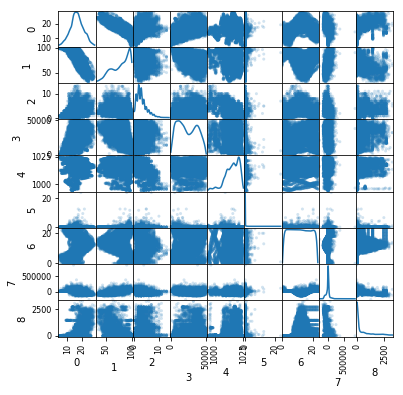

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

#Merge energy and solar energy produced into feature array
mergedMatrix = np.c_[featureArray,labels,labels_solar]
#Create a pandas dataframe for viz
scatterMatrix = mergedMatrix[:,2:].astype(float)
df = pd.DataFrame(data = scatterMatrix
                  #columns = ['Temp','humidity',
                  #            'wind speed','visibility',
                  #            'rain','Day Hour',
                  #            'net energy','solar']
                 )

pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal='kde')

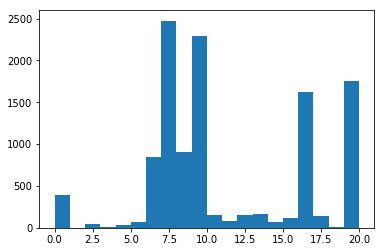

(11328, 13)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3b4d840208>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f3b4d4efd30>]], dtype=object)

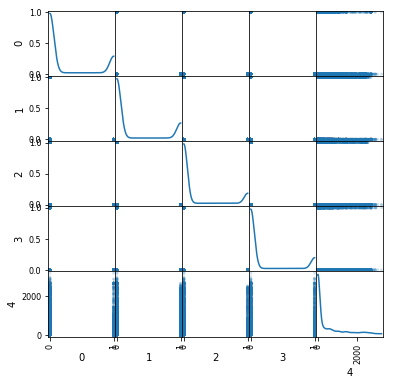

In [28]:
transMatrix = transform_text_labels(featureArray)
merge = np.c_[featureArray,transMatrix]
merge_hot = np.c_[transMatrix,labels_solar]
print(merge.shape)
scatterMatrix = merge_hot.astype(float)
df = pd.DataFrame(data = scatterMatrix)

pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal='kde')


## Creating a regression model

At this point, we have a clean feature matrix (split into 3 sets) with the corresponding set of labels. Define a helper function to calculate the prediction error for validations and test sets. Define another function that normalizes the feature vector columns. 

Finally use the regression model from scikit-learn to fit training data. Tweak parameters and check their effect by calculating the prediction error for the validation set.

When the best set of parameters are found, check the prediction error on the test-set.

In [29]:
def prediction_error(labels_predict,labels_true):
    """
    Calculates the prediction error as the average absolute difference 
    between predicted and true labels
    
    """
    error = 0
    for predicted,true in zip(labels_predict,labels_true):
        #print('True : {} Predicted : {}'.format(true,predicted))
        error += abs(predicted-true)
    
    error = error/len(labels_predict)
    return error

def normalize_data(data):
    """
    Scales data to [-1,1], to be done before feeding it for regression
    
    """
    scaler = StandardScaler()
    fit = scaler.fit_transform(data)
    return fit

#Split the dataset
data_train,labels_train,data_val,labels_val,data_test,labels_test = split_dataset(featureArray,labels_solar)

# SGD Regression (Don't normalize the one hot encoded labels !)
X_train = normalize_data(data_train[:,2:].astype(float))
X_val = normalize_data(data_val[:,2:].astype(float))
X_test = normalize_data(data_test[:,2:].astype(float))
clf = linear_model.SGDRegressor(max_iter = 10**6/X_train.shape[0],
                                tol = 1e-6,
                                alpha = 0.1,
                                )
clf.fit(X_train,labels_train)

print(clf.coef_)
print(clf.score(X_train,labels_train))
print(clf.score(X_val,labels_val))
print(clf.score(X_test,labels_test))



[  65.61118007 -241.05702123   27.58696487  -65.94313814   44.46270513
   -6.20136843   43.74968555]
0.264807939766
0.163219096534
0.321556685642


In [30]:
# Ridge Regression
ridge = linear_model.Ridge(alpha=10.0)
ridge.fit(X_train,labels_train)
print(ridge.coef_)
print(ridge.score(X_train,labels_train))

print(ridge.score(X_val,labels_val))
print(ridge.score(X_test,labels_test))


[  23.33927318 -335.25404983   22.44133077 -129.50273559   43.64709534
   -0.60083788   48.32225944]
0.272917376522
0.129108438032
0.302296708134


In [31]:
# Lasso Regression
lasso = linear_model.Lasso(alpha=10.0)
lasso.fit(X_train,labels_train)
print(lasso.coef_)
print(lasso.score(X_train,labels_train))

print(lasso.score(X_val,labels_val))
print(lasso.score(X_test,labels_test))
print(X_train.shape)

[  26.4354626  -314.33606694    3.09562101  -98.21533964   27.32292444
   -0.           32.68596946]
0.270110857736
0.150170245057
0.303655423902
(7440, 7)


In [32]:
#Polynomial Features
poly = PolynomialFeatures(degree = 2)
poly_X_train = poly.fit_transform(X_train)
poly_X_val = poly.fit_transform(X_val)
poly_X_test = poly.fit_transform(X_test)

# Lasso Regression
lasso_poly = linear_model.Lasso(alpha=0.1)
lasso_poly.fit(poly_X_train,labels_train)
print(lasso_poly.coef_)
print(lasso_poly.score(poly_X_train,labels_train))

#print(prediction_error(lasso_poly.predict(poly_X_val),labels_val))
#print(prediction_error(lasso_poly.predict(poly_X_test),labels_test))

print(lasso_poly.score(poly_X_val,labels_val))
print(lasso_poly.score(poly_X_test,labels_test))


[   0.           16.50486706 -210.24120128   69.08708479  -84.27371755
   89.4967927    30.66872888   29.78721151   86.66586038   30.39216242
  -21.58165364    3.83541079  -72.62997525    0.30704867  -72.46519894
  155.42847064  -19.00231031  132.3312442   -69.61175813   -8.25033228
   27.2921203   -11.27320483  -17.87997164    0.62599309   -5.86900544
   67.0470636    30.67876983  -17.66036456   10.62384308  -15.82065713
   22.38511602   18.31591517   53.2284171    -0.36154849  -20.25094568
  -27.12212284]
0.354206290544
0.137836855087
0.172238636221


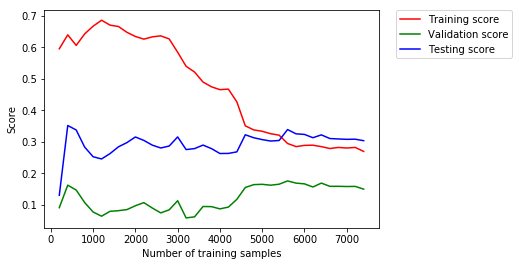

In [33]:
#Plotting test and generalization errors
#Split the dataset
data_train,label_train,data_val,label_val,data_test,label_test = split_dataset(featureArray,labels_solar)
num_train_examples = data_train.shape[0]
num_samples = 200
train_error = []
val_error = []
test_error = []
samples = []
X_train = normalize_data(data_train[:,2:].astype(float))
X_val = normalize_data(data_val[:,2:].astype(float))
X_test = normalize_data(data_test[:,2:].astype(float))
while num_samples < num_train_examples:
    samples.append(num_samples)
    # Lasso Regression
    lasso = linear_model.Lasso(alpha=10.0)
    lasso.fit(X_train[0:num_samples,:],labels_train[0:num_samples])
    train_error.append(lasso.score(X_train[0:num_samples,:],labels_train[0:num_samples]))
    val_error.append(lasso.score(X_val,labels_val))
    test_error.append(lasso.score(X_test,labels_test))
    num_samples += 200

#Plot the curves
plt.plot(samples,train_error,'r',label='Training score')
plt.plot(samples,val_error,'g',label='Validation score')
plt.plot(samples,test_error,'b',label='Testing score')
plt.ylabel('Score')
plt.xlabel('Number of training samples')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
plt.show()

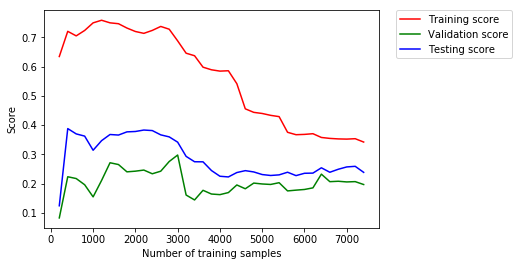

In [34]:
#Plotting test and generalization errors
#Split the dataset
data_train,label_train,data_val,label_val,data_test,label_test = split_dataset(featureArray,labels_solar)
num_train_examples = data_train.shape[0]
num_samples = 200
train_error = []
val_error = []
test_error = []
samples = []
X_train = normalize_data(data_train[:,2:].astype(float))
X_val = normalize_data(data_val[:,2:].astype(float))
X_test = normalize_data(data_test[:,2:].astype(float))
poly = PolynomialFeatures(degree = 2)
poly_X_train = poly.fit_transform(X_train)
poly_X_val = poly.fit_transform(X_val)
poly_X_test = poly.fit_transform(X_test)
while num_samples < num_train_examples:
    samples.append(num_samples)
    # Lasso Regression
    lasso = linear_model.Lasso(alpha=10.0)
    lasso.fit(poly_X_train[0:num_samples,:],labels_train[0:num_samples])
    train_error.append(lasso.score(poly_X_train[0:num_samples,:],labels_train[0:num_samples]))
    val_error.append(lasso.score(poly_X_val,labels_val))
    test_error.append(lasso.score(poly_X_test,labels_test))
    num_samples += 200

#Plot the curves
plt.plot(samples,train_error,'r',label='Training score')
plt.plot(samples,val_error,'g',label='Validation score')
plt.plot(samples,test_error,'b',label='Testing score')
plt.ylabel('Score')
plt.xlabel('Number of training samples')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
plt.show()

In [35]:
#Pickle all the data
import pickle

with open('data_train.pkl', 'wb') as f:
    pickle.dump(list(X_train), f)

with open('labels_train.pkl', 'wb') as f:
    pickle.dump(list(labels_train), f)
    
with open('data_val.pkl', 'wb') as f:
    pickle.dump(list(X_val), f)

with open('labels_val.pkl', 'wb') as f:
    pickle.dump(list(labels_val), f)

with open('data_test.pkl', 'wb') as f:
    pickle.dump(list(X_test), f)

with open('labels_test.pkl', 'wb') as f:
    pickle.dump(list(labels_test), f)